In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import pow
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
from sklearn.metrics import r2_score
from ipywidgets import IntProgress
import scipy.optimize as opt
from scipy import integrate
# sns.set_theme()

In [37]:
df = pd.read_csv("Data/Grim/data.csv", index_col=0)

In [38]:
def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude


def ft_to_meters(ft): return ft * 0.3048

In [39]:
boost_end = 3_500
first_charge = 28_125

In [40]:
altim = df[['pressure (kPa)']].copy()

In [41]:
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

Text(0.5, 1.0, 'Measured Altimeter Altitude')

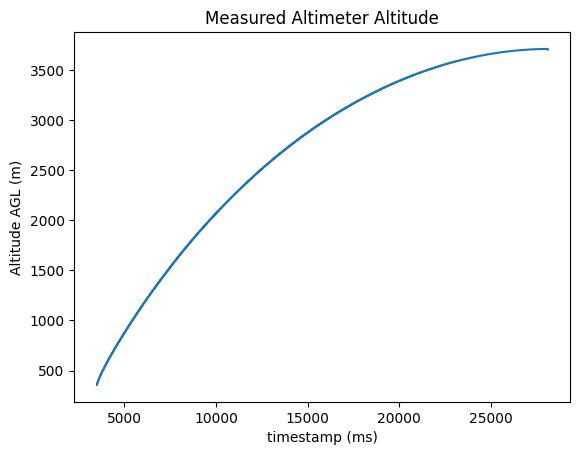

In [42]:
fig = altim.loc[boost_end:first_charge]['alt_m_agl'].plot()
fig.set_ylabel("Altitude AGL (m)")
fig.set_title("Measured Altimeter Altitude")

In [43]:
nice_data = altim.loc[boost_end:first_charge].copy()
nice_data.index = nice_data.index.to_series() / 1000.0
nice_data.index.set_names("timestamp", inplace=True)

In [44]:
nice_data['t'] = nice_data.index

In [45]:
nice_data

,pressure (kPa),alt_m_asl,alt_m_agl,t
timestamp,,,,
3.502,83.018967,1648.553042,356.325308,3.502
3.506,83.018967,1648.553042,356.325308,3.506
3.509,82.812447,1668.766340,376.538606,3.509
3.513,82.812447,1668.766340,376.538606,3.513
3.516,82.812447,1668.766340,376.538606,3.516
...,...,...,...,...
28.109,54.010750,4999.179527,3706.951794,28.109
28.113,54.010750,4999.179527,3706.951794,28.113
28.116,54.010750,4999.179527,3706.951794,28.116


In [46]:
actual_apogee, actual_apogee_index = nice_data['alt_m_agl'].max(), nice_data['alt_m_agl'].argmax() 
actual_apogee_time = nice_data.iloc[actual_apogee_index].t
print(actual_apogee, actual_apogee_time)

3712.8837039159207 28.056


In [47]:

def curve_fit_to_now(row):
    endt = row.name
    data = nice_data[:endt]

    poly = np.polyfit(data.index, data['alt_m_agl'], 2)
    predictor = np.poly1d(poly)
    outs = predictor(nice_data.index)
    predicted_apogee, predicted_apogee_index = outs.max(), outs.argmax()
    predicted_apogee_time = nice_data.iloc[predicted_apogee_index].name
    # print(time_difference)
    if predicted_apogee > 10_000:
        predicted_apogee = 10_000
    elif predicted_apogee < 0:
        return 0
    pred_alt = predictor(endt)
    return pred_alt, predicted_apogee, predicted_apogee_time, poly[0], poly[1], poly[2]

In [48]:
fdata = nice_data.copy()

In [49]:
fdata[['pred_alt', 'pred_apogee', 'pred_apogee_t', 'e0', 'e1', 'e2']] = fdata.apply(curve_fit_to_now, axis=1, result_type='expand')

/tmp/ipykernel_53772/3293187118.py:5: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)
/tmp/ipykernel_53772/3293187118.py:5: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(data.index, data['alt_m_agl'], 2)


In [50]:
fdata['apogee_diff'] = actual_apogee - fdata['pred_apogee']
fdata['apogee_diff_t'] = actual_apogee_time - fdata['pred_apogee_t']
fdata['alt_diff'] = fdata['alt_m_agl'] - fdata['pred_alt']

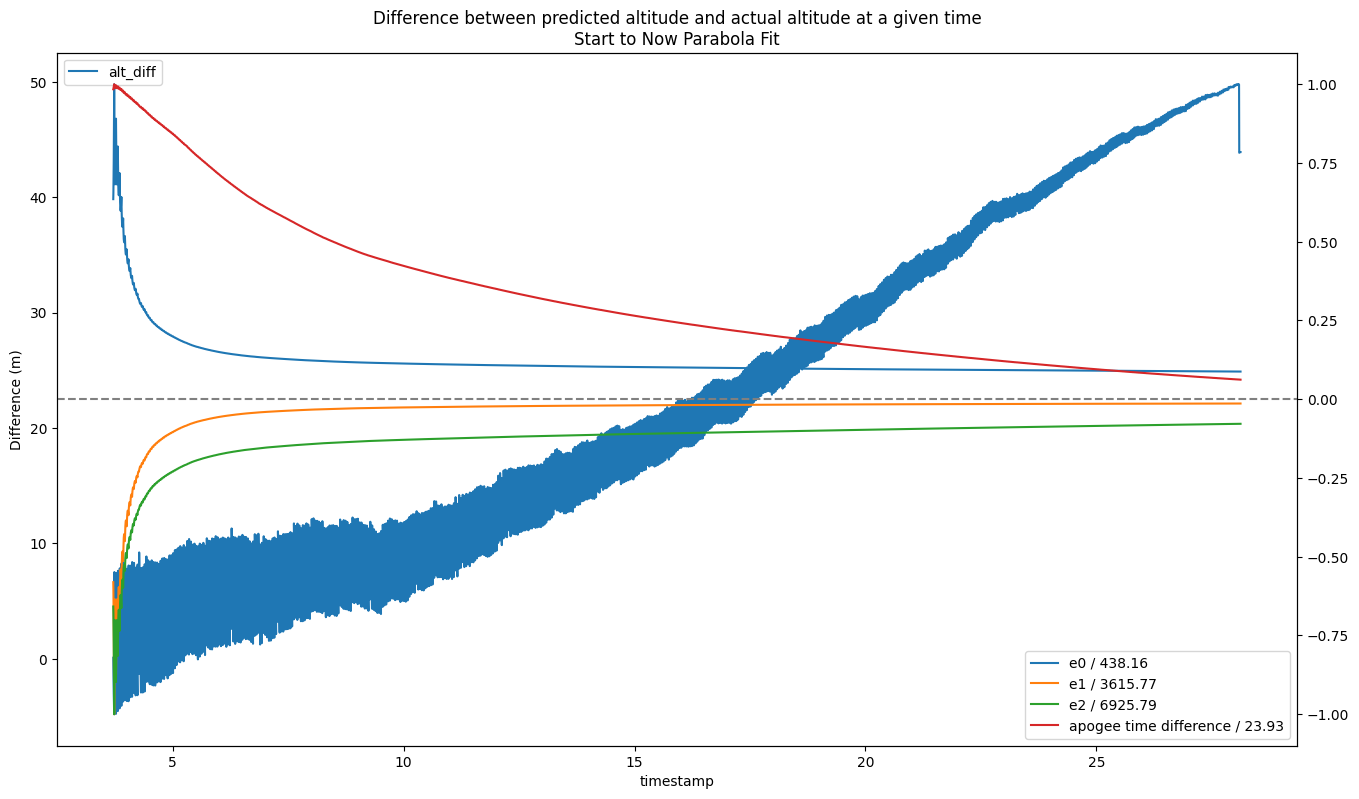

In [51]:
wdata = fdata.iloc[60:]

me0 = wdata['e0'].abs().max()
me1 = wdata['e1'].abs().max()
me2 = wdata['e2'].abs().max()

fig = wdata['alt_diff'].plot(figsize = (16, 9))
tx = fig.twinx()
tx.plot(wdata['e1'] / me1, label = f"e0 / {me0:.2f}")
tx.plot(wdata['e0'] / me0, label = f"e1 / {me1:.2f}")
tx.plot(wdata['e2'] / me2, label = f"e2 / {me2:.2f}")


madt = wdata['apogee_diff_t'].abs().max()
tx.plot(wdata['apogee_diff_t'] / madt, label = f"apogee time difference / {madt:.2f}")


tx.axhline(0, c = 'gray', linestyle = 'dashed')

fig.set_title("Difference between predicted altitude and actual altitude at a given time\nStart to Now Parabola Fit")
fig.set_ylabel("Difference (m)")
fig.legend()
tx.legend(loc = 'lower right')

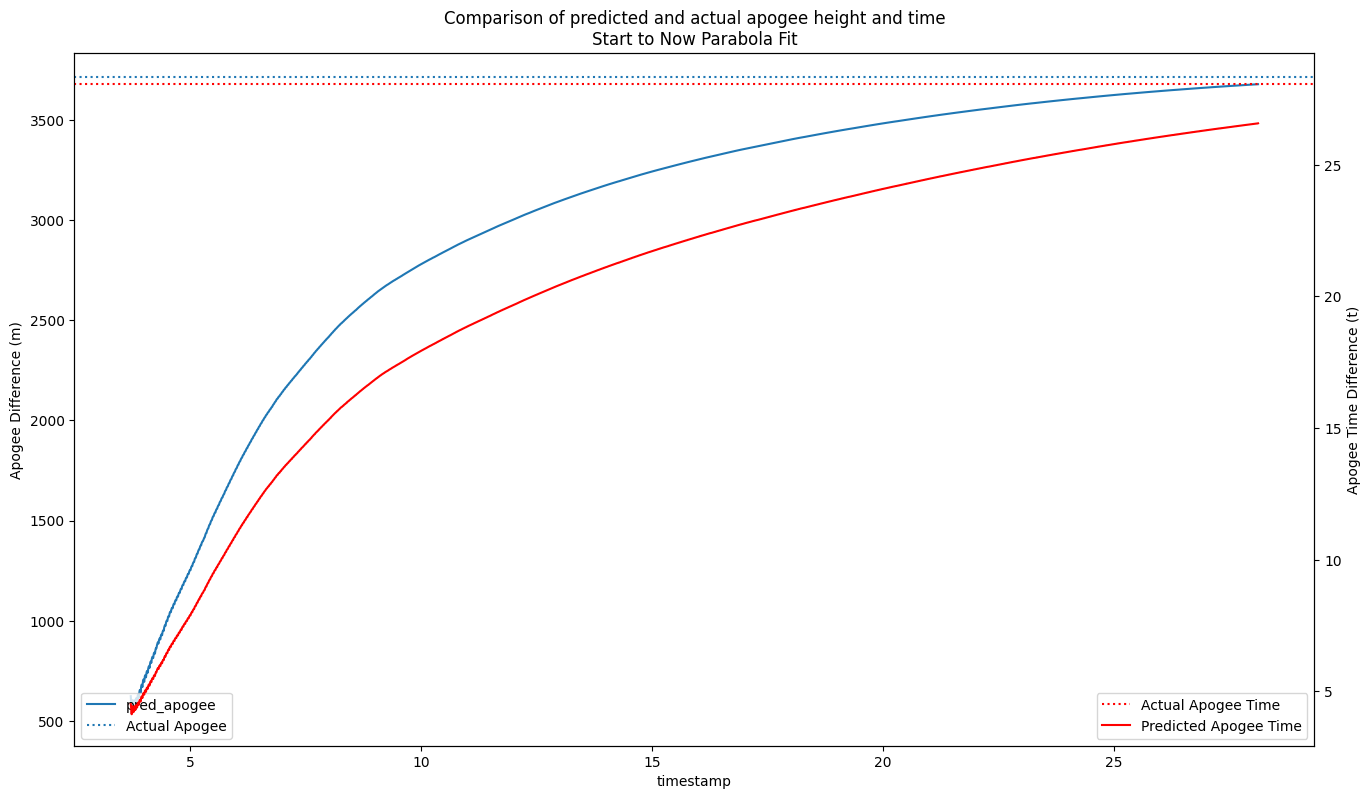

In [52]:
wdata = fdata.iloc[60:]

p = wdata[['pred_apogee']].plot(figsize=(16,9))
p.axhline(actual_apogee, linestyle='dotted', label = 'Actual Apogee')
p.legend(loc = 'lower left')

tx = p.twinx()
tx.axhline(actual_apogee_time, linestyle='dotted', c = 'red', label = "Actual Apogee Time")
tx.plot(wdata['pred_apogee_t'], c = 'red', label = 'Predicted Apogee Time')

tx.legend(loc = 'lower right')
p.set_title("Comparison of predicted and actual apogee height and time\nStart to Now Parabola Fit")
p.set_ylabel("Apogee Difference (m)")
tx.set_ylabel("Apogee Time Difference (t)");

Measuring model performance
integral of error over time
if we're accurate the whole time, we'll have a smaller number

if were bad for half but good for the other, medium number

if were bad the whole time, big number

we want the littlest score

In [53]:
apogee_score = integrate.trapezoid(wdata.apogee_diff, wdata.index)
apogee_time_score = integrate.trapezoid(wdata.apogee_diff_t, wdata.index)

print(f"Apogee Prediction Score: {apogee_score:.3f}")
print(f"Apogee Time Prediction Score: {apogee_time_score:.3f}")

Apogee Prediction Score: 17206.028
Apogee Time Prediction Score: 186.042


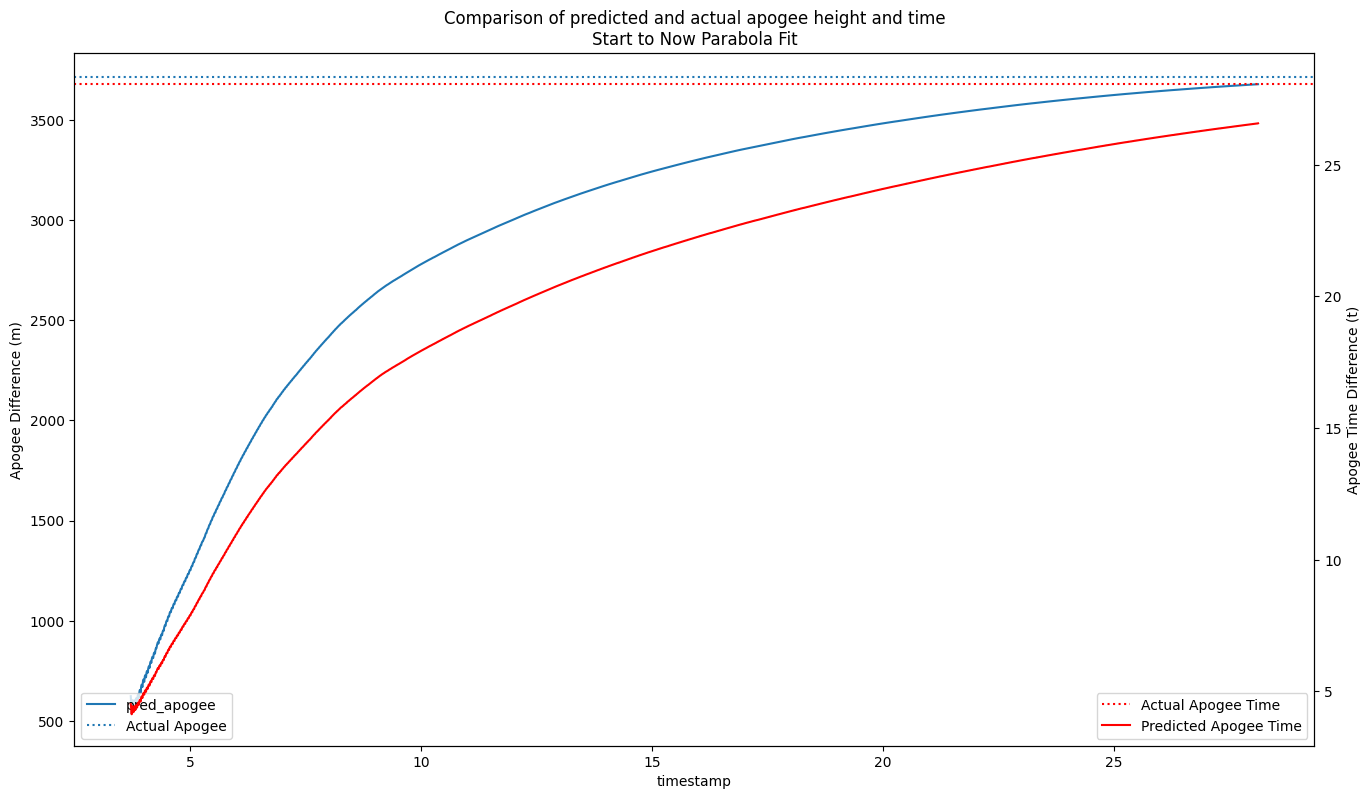

In [54]:
wdata = fdata.iloc[60:]

p = wdata[['pred_apogee']].plot(figsize=(16,9))
p.axhline(actual_apogee, linestyle='dotted', label = 'Actual Apogee')
p.legend(loc = 'lower left')

tx = p.twinx()
tx.axhline(actual_apogee_time, linestyle='dotted', c = 'red', label = "Actual Apogee Time")
tx.plot(wdata['pred_apogee_t'], c = 'red', label = 'Predicted Apogee Time')

tx.legend(loc = 'lower right')
p.set_title("Comparison of predicted and actual apogee height and time\nStart to Now Parabola Fit")
p.set_ylabel("Apogee Difference (m)")
tx.set_ylabel("Apogee Time Difference (t)");